Originally published to Kaggle.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
with sqlite3.connect('data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

In [3]:
selected_countries = ['England','France','Spain']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id','home_team_goal', 'away_team_goal','B365H','B365D','B365A']]
# 'stage', 'date','match_api_id', removed columns
matches.dropna(inplace=True)

In [4]:
### Convert Goals Scored into Results
matches['D'] = np.where(matches.home_team_goal == matches.away_team_goal,1,0)
matches['HW'] = np.where(matches.home_team_goal > matches.away_team_goal,1,0)
matches['AW'] = np.where(matches.home_team_goal < matches.away_team_goal,1,0)
del matches['home_team_goal']
del matches['away_team_goal']

In [5]:
### Convert odds into implied probability assuming no bias in where the margin lies
matches['B365Norm'] = 1/(1/matches.B365H + 1/matches.B365A + 1/matches.B365D)

In [6]:
matches['B365H'] = (1/matches.B365H)*matches.B365Norm
matches['B365A'] = (1/matches.B365A)*matches.B365Norm
matches['B365D'] = (1/matches.B365D)*matches.B365Norm
matches.head(n=2) #eyeball that probablities sum to one

,id,B365H,B365D,B365A,D,HW,AW,B365Norm
1728,1729,0.739744,0.173504,0.086752,1,0,0,0.954270
1729,1730,0.790754,0.145985,0.063260,0,1,0,0.948905


/home/phillip/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/phillip/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


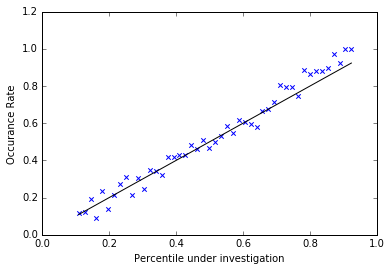

In [11]:
percentile = list(np.linspace(0.10,0.95,num=49))
m = (percentile[1]-percentile[0])/2
estimator = []
for Z in [(x,y) for x,y in zip(percentile, percentile[1:])]:
    t  = matches[matches.B365H > Z[0]][matches.B365H < Z[1]].shape[0]
    tp = matches[matches.B365H > Z[0]][matches.B365H < Z[1]][matches.HW==1].shape[0]
    if t > 0: 
        estimator.append(tp/t)
    else:
        percentile.remove(Z[0])

plt.scatter(percentile[:-1]+m,estimator,marker='x')
plt.plot(percentile[:-1]+m,percentile[:-1]+m,color='k')
plt.xlabel('Percentile under investigation')
plt.ylabel('Occurance Rate')

In [8]:
print(round(np.mean(np.abs(np.subtract(estimator,percentile[:-1])-m))*100,2))
## how far wrong is the biggest error?

3.85
